In [1]:
import numpy as np
from sklearn.datasets import load_iris

In [2]:
from sporgboost.preprocessing import onehot_encode, shuffle
from sporgboost.common import find_split, best_split

In [3]:
# Dataset for testing
X, y = load_iris(return_X_y = True)

# Set seed to be able to reproduce
np.random.seed(1234)
    
# Preprocessing
y = onehot_encode(y)
X, y = shuffle(X, y)

In [4]:
find_split(X, y)

array([[6.        , 0.41934923],
       [3.3       , 0.54789331],
       [4.5       , 0.35805596],
       [1.4       , 0.35799545]])

In [12]:
from sklearn.tree import DecisionTreeClassifier
sktree = DecisionTreeClassifier(
    
)
sktree.fit(X, y)

DecisionTreeClassifier()

array([[6.        , 0.41934923],
       [3.3       , 0.54789331],
       [4.5       , 0.35805596],
       [1.4       , 0.35799545]])

In [7]:
y_ = onehot_encode(np.array([0,0,0,0,0,1,1,1,1,1]))
X_ = np.array([
    [0,33],
    [0,54],
    [0,56],
    [0,42],
    [1,50],
    [1,55],
    [1,31],
    [0,-4],
    [1,77],
    [0,49]
    ])
# A	0	33	
# A	0	54	
# A	0	56	
# A	0	42	
# A	1	50	
# B	1	55	
# B	1	31	
# B	0	-4	
# B	1	77	
# B	0	49

In [85]:
le = X_ == 1
# y_[le]
gini_left = 1 - (y_[le].mean(axis=0) ** 2).sum()
gini_right = 1 - (y_[~le].mean(axis=0) ** 2).sum()
w = le.sum() / le.shape[0]
gini_left * w + gini_right * (1-w)

0.4166666666666667

In [108]:
l = gini_impunity(y_[:-1])
r = np.flip(gini_impunity(np.flip(y_[1:])))


In [141]:
np.unique(X[:,0], return_index=True)

(array([4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5,
        5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8,
        6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.6, 7.7, 7.9]),
 array([108,  11,  97,   3,   5,  29,  45,   7,  30,   4,  25,  37,  40,
         19,   8,  10,  13,  68,   0,  31,   2,  20,  21,  58,  18, 133,
         43, 134,  28,  24, 120,  61,  52,   9,  75], dtype=int64))

In [198]:
from numba import njit, prange

@njit
def collapse_levels(X, y):
    # Get unique levels of X
    X_unique = np.unique(X)
    y_agg = np.empty((X_unique.shape[0], y.shape[1]))
    n = np.empty((X_unique.shape[0]))
    for p in prange(0, X_unique.shape[0]):
        x_target = X_unique[p]
        y_agg[p, :] = row_mean(y[X == x_target])
        n[p] = y[X == x_target].shape[0]

    return X_unique, y_agg, n

X2, y2, n = collapse_levels(X_, y_)

In [213]:
X2

array([0, 1])

In [214]:
y2

array([[0.66666667, 0.33333333],
       [0.25      , 0.75      ]])

In [212]:
n

array([6., 4.])

In [219]:
from sporgboost.utils import row_cumsum

@njit
def gini_impunity(y):
    ''' Computes gini impunity for a given partition of data
    
    Args:
        y (Array): 2-d vector of normalized 
    '''
    return 1 - (y ** 2).sum(axis=1)

In [211]:
((row_cumsum(y2) / row_cumsum(n[:,np.newaxis])) ** 2).sum(axis=1)

array([0.0154321 , 0.02013889])

In [220]:
gini_impunity(y2)

array([0.44444444, 0.375     ])

In [195]:
%timeit collapse_levels(X_, y_)

5.2 µs ± 24.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [192]:
%timeit collapse_levels(X_, y_)

32.8 µs ± 407 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [112]:
w = np.arange(1,10) / 10
l * w + (1-w) * r

array([0.44444444, 0.375     , 0.28571429, 0.16666667, 0.32      ,
       0.41666667, 0.28571429, 0.375     , 0.44444444])

In [115]:
weighted_gini(l,r) == l * w + (1-w) * r

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [113]:
gini_impunity(y_)

array([0.        , 0.        , 0.        , 0.        , 0.32      ,
       0.44444444, 0.40816327, 0.46875   , 0.49382716, 0.5       ])

In [94]:
2/6

0.3333333333333333

In [80]:
X_, y_ = sort_pair(X_[:,0], y_)

In [84]:
gini_impunity(y_)

array([0.        , 0.        , 0.        , 0.        , 0.32      ,
       0.44444444, 0.40816327, 0.46875   , 0.49382716, 0.5       ])

In [56]:
(X_[:,0] == 1).sum()
(X_[:,0] != 1).sum()


6

In [51]:
le = X[:,2] <= 2.25
n = len(le)
gini_left = 1 - (y[le].mean(axis=0) ** 2).sum()
gini_right = 1 - (y[~le].mean(axis=0) ** 2).sum()
w = le.sum() / n
gini_left * n + gini_right * (1 - w)

0.33333333333333337

In [ ]:
from sporgboost.common import gini_impunity
gini_impunity(y_)

In [47]:
y[~le].mean(axis=0) ** 2

array([0.  , 0.25, 0.25])

[Text(0.5, 0.9166666666666666, 'X[2] <= 2.45\ngini = 0.444\nsamples = 150\nvalue = [[100, 50]\n[100, 50]\n[100, 50]]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [[0, 50]\n[50, 0]\n[50, 0]]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.333\nsamples = 100\nvalue = [[100, 0]\n[50, 50]\n[50, 50]]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.112\nsamples = 54\nvalue = [[54, 0]\n[5, 49]\n[49, 5]]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.027\nsamples = 48\nvalue = [[48, 0]\n[1, 47]\n[47, 1]]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [[47, 0]\n[0, 47]\n[47, 0]]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[1, 0]\n[0, 1]]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.296\nsamples = 6\nvalue = [[6, 0]\n[4, 2]\n[2, 4]]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [[3, 0]\n[3, 0]\n[0, 

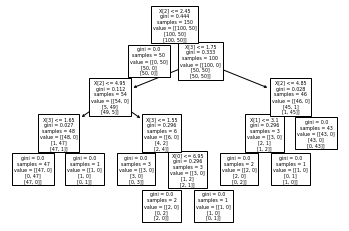

In [25]:
from sklearn.tree import plot_tree
plot_tree(sktree)

In [15]:
from sklearn.tree._tree import Tree
help(Tree) 

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [13]:
dir(sktree)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 'apply',
 'ccp_alpha',
 'class_weight',
 'classes_',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samp

In [9]:
from numba.experimental import jitclass
from numba import float32, int16
from sporgboost.projections import Identity
from sporgboost.common import gini_impunity
from sporgboost.utils import row_mean

class DecisionStump():
    def __init__(self,
                 base_proj = Identity,
                 **kwargs
                ):
        self.base_proj = base_proj
        self.proj = base_proj()
    
    def fit(self, X, y):
        # General info
        self.n_classes = y.shape[1]
        
        # Project the data onto a new hyperplane
        self.proj.fit(X, y)
        X_proj = self.proj.transform(X)
        
        # Set the split col and value
        self.col_idx, self.value = best_split(X_proj, y)
        self.proj.select(self.col_idx)
        
        # Check partitions for impunity and decide if we are adding a leaf or another stump
        le = (X_proj[:, self.col_idx] <= self.value)
        left_value = row_mean(y[le])
        right_value = row_mean(y[~le])

        if (le.sum() == X.shape[0]) or (le.sum() == 0):
            raise ValueError(f"One partition is entirely empty, returning diagnostic info"
                             f"\nX:\n{X}\ny:\n{y}\ncol_idx={self.col_idx}\nsplit_value={self.value}"
                             f"\nfind_split_info={find_split(X_proj, y)}"
                            )
            
        if left_value.max() == 1:
            self.left = left_value  
        else:
            self.left = DecisionStump(proj = self.proj).fit(X[le], y[le])
            
        if right_value.max() == 1:
            self.right = right_value 
        else:
            self.right = DecisionStump(proj = self.proj).fit(X[~le], y[~le])

        return self
    
    def predict(self, X):
        X_proj = self.proj.transform(X)
        y_pred = np.empty((X.shape[0], self.n_classes), 'float32')
        
        le = (X_proj <= self.value).flatten()
        if isinstance(self.left, DecisionStump):
            y_pred[le, :] = self.left.predict(X[le])
        else:
            y_pred[le, :] = self.left
        
        if isinstance(self.right, DecisionStump):
            y_pred[~le, :] = self.right.predict(X[~le])
        else:
            y_pred[~le, :] = self.right
            
        y_pred[X_proj > self.value] = self.right.predict(X[X_proj > self.value])
        return(y_pred)

In [10]:
%%time
test = DecisionStump()
test.fit(X, y)

ValueError: One partition is entirely empty, returning diagnostic info
X:
[[4.6 3.4 1.4 0.3]
 [5.2 2.7 3.9 1.4]
 [4.7 3.2 1.6 0.2]
 [5.2 3.5 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.7 2.8 4.1 1.3]
 [5.8 2.7 3.9 1.2]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.7 2.6 3.5 1. ]
 [5.  3.  1.6 0.2]
 [5.3 3.7 1.5 0.2]
 [5.8 2.6 4.  1.2]
 [4.8 3.4 1.6 0.2]
 [5.1 2.5 3.  1.1]
 [5.  3.5 1.3 0.3]
 [4.8 3.4 1.9 0.2]
 [4.4 2.9 1.4 0.2]
 [5.4 3.4 1.7 0.2]
 [4.6 3.6 1.  0.2]
 [5.  2.3 3.3 1. ]
 [5.5 3.5 1.3 0.2]
 [5.2 4.1 1.5 0.1]
 [4.9 3.1 1.5 0.1]
 [4.9 3.  1.4 0.2]
 [4.9 2.4 3.3 1. ]
 [5.6 2.9 3.6 1.3]
 [5.1 3.5 1.4 0.3]
 [5.1 3.4 1.5 0.2]
 [5.1 3.7 1.5 0.4]
 [5.5 4.2 1.4 0.2]
 [5.1 3.5 1.4 0.2]
 [6.  2.2 4.  1. ]
 [5.  3.6 1.4 0.2]
 [5.4 3.7 1.5 0.2]
 [5.7 4.4 1.5 0.4]
 [5.6 3.  4.1 1.3]
 [5.4 3.9 1.7 0.4]
 [5.8 2.7 4.1 1. ]
 [5.  3.4 1.5 0.2]
 [5.7 3.8 1.7 0.3]
 [5.  3.3 1.4 0.2]
 [5.1 3.8 1.9 0.4]
 [4.5 2.3 1.3 0.3]
 [5.4 3.9 1.3 0.4]
 [4.8 3.  1.4 0.3]
 [5.5 2.5 4.  1.3]
 [5.4 3.4 1.5 0.4]
 [4.3 3.  1.1 0.1]
 [5.2 3.4 1.4 0.2]
 [5.1 3.8 1.6 0.2]
 [5.  2.  3.5 1. ]
 [6.1 2.8 4.  1.3]
 [5.8 4.  1.2 0.2]
 [5.5 2.4 3.7 1. ]
 [4.8 3.  1.4 0.1]
 [5.1 3.8 1.5 0.3]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [4.9 3.1 1.5 0.2]
 [4.9 3.6 1.4 0.1]
 [5.5 2.4 3.8 1.1]
 [5.6 2.5 3.9 1.1]
 [5.  3.4 1.6 0.4]
 [4.8 3.1 1.6 0.2]
 [5.1 3.3 1.7 0.5]
 [5.5 2.3 4.  1.3]
 [4.4 3.  1.3 0.2]
 [4.6 3.2 1.4 0.2]]
y:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
col_idx=2
split_value=4.1
find_split_info=[[6.         0.17292957]
 [3.         0.20393694]
 [4.1        0.08315066]
 [1.3        0.08315066]]

In [8]:
test.left

AttributeError: 'DecisionStump' object has no attribute 'left'